In [1]:
import sys
sys.path.append("..")
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [4, 4]

from engression import engression
from engression.data.loader import partition_data

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load data
data = pd.read_csv("../engression/data/resources/air_quality.csv")
x_full = torch.Tensor(data["PT08.S2.NMHC."]).unsqueeze(1).to(device)
y_full = torch.Tensor(data["PT08.S3.NOx."]).unsqueeze(1).to(device)
# partition training/test
x_tr, y_tr, x_te, y_te, x_full_normal = partition_data(x_full, y_full, 0.3, "smaller")

In [4]:
# Fit an engression model
engressor = engression(x_tr, y_tr, num_layer=5, hidden_dim=100, noise_dim=100, 
                       lr=0.01, num_epoches=1000, batch_size=3000, print_every_nepoch=500, device=device)

Running on CPU.

Data is standardized during training only; the printed training losses are on the standardized scale, 
while during evaluation, the predictions, evaluation metrics, and plots will be on the original scale.

Batch is larger than half of the sample size. Training based on full-batch gradient descent.
[Epoch 1 (0%)] energy-loss: 0.6606,  E(|Y-Yhat|): 0.8399,  E(|Yhat-Yhat'|): 0.3588
[Epoch 500 (50%)] energy-loss: 0.3734,  E(|Y-Yhat|): 0.7477,  E(|Yhat-Yhat'|): 0.7487
[Epoch 1000 (100%)] energy-loss: 0.3903,  E(|Y-Yhat|): 0.7669,  E(|Yhat-Yhat'|): 0.7532

Training loss on the original (non-standardized) scale:
	Energy-loss: 0.3784,  E(|Y-Yhat|): 0.7586,  E(|Yhat-Yhat'|): 0.7604

Prediction-loss E(|Y-Yhat|) and variance-loss E(|Yhat-Yhat'|) should ideally be equally large
-- consider training for more epochs or adjusting hyperparameters if there is a mismatch 


In [5]:
# Summarize model information
engressor.summary()

Engression model with
	 number of layers: 5
	 hidden dimensions: 100
	 noise dimensions: 100
	 number of epochs: 1000
	 batch size: 2707
	 learning rate: 0.01
	 standardization: True
	 training mode: False
	 device: cpu

Training loss (original scale):
	 energy-loss: 0.38, 
	E(|Y-Yhat|): 0.76, 
	E(|Yhat-Yhat'|): 0.76


In [6]:
# Evaluation
print("L2 loss:", engressor.eval_loss(x_te, y_te, loss_type="l2"))
print("correlation between predicted and true means:", engressor.eval_loss(x_te, y_te, loss_type="cor"))
print("energy score:", engressor.eval_loss(x_te, y_te, loss_type="energy"))

L2 loss: 0.3094285726547241
correlation between predicted and true means: 0.6968534588813782
energy score: 0.30452460050582886


In [7]:
# prediction
y_pred = engressor.predict(x_full_normal)

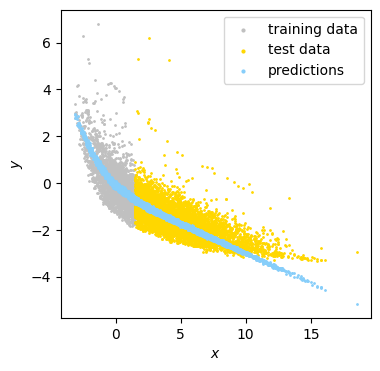

In [8]:
engressor.plot(x_te, y_te, x_tr, y_tr)

## Baseline: $L_2$ regression

In [9]:
from engression.models import Net

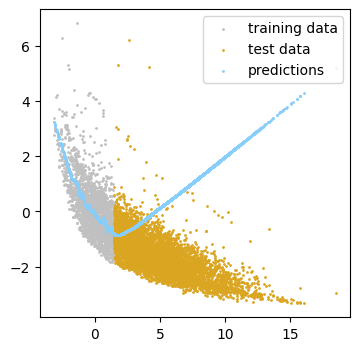

In [10]:
# Build a model with the same architecture
model = Net(num_layer=5, hidden_dim=100) # NN with the same architecture
opt = torch.optim.Adam(model.parameters(), lr=0.01) # same optimizer

# L2 regression training
model.train()
for i in range(1000):
    model.zero_grad()
    y_pred = model(x_tr)
    loss = (y_pred - y_tr).pow(2).mean()
    loss.backward()
    opt.step()

# Evaluation
model.eval()
y_pred = model(x_full_normal).detach()
plt.scatter(x_tr.cpu(), y_tr.cpu(), label="training data", s=1, color="silver")
plt.scatter(x_te.cpu(), y_te.cpu(), label="test data", s=1, color="goldenrod")
plt.scatter(x_full_normal.cpu(), y_pred.cpu(), label="predictions", s=1, color="lightskyblue")
plt.legend(); plt.show()